# Stroke Prediction Analysis

## Introduction
Stroke is the second leading cause of death globally, accounting for approximately 11% of total deaths, according to the World Health Organization (WHO). Given the significant impact of stroke on public health, early detection and intervention are crucial in reducing morbidity and mortality associated with this condition. This project aims to analyze a dataset that contains various clinical features to predict the likelihood of stroke occurrence in patients.

The dataset comprises 11 clinical attributes, including demographic information, medical history, and lifestyle factors, such as gender, age, hypertension, heart disease, and smoking status. By utilizing machine learning techniques, we aim to develop predictive models that can effectively identify individuals at high risk for stroke. Understanding these risk factors will facilitate timely interventions and promote better health outcomes.

Through exploratory data analysis (EDA) and predictive modeling, this project seeks to uncover valuable insights into the determinants of stroke risk, contributing to improved prevention strategies and healthcare policies.

## Table of Contents
1. [Package Installation](#package-installation)
2. [Library Imports](#library-imports)
3. [Data Loading](#data-loading)
4. [Data Preparation](#data-visualization)
5. [Correlation Analysis](#correlation-analysis)
6. [Modeling](#modeling)
7. [Model Evaluation](#model-evaluation)
8. [Conclusion and Next Steps](#conclusion-and-next-steps)

## Package Installation <a name="package-installation"></a>
In this cell, we will install the necessary Python packages required for our data analysis project. This step ensures that all the libraries needed for data manipulation, visualization, and machine learning are available in our environment. 

We will use the `pip` command to install the following libraries:

- **NumPy**: A library for numerical computations and handling arrays.
- **Pandas**: A powerful data manipulation and analysis library, particularly useful for working with structured data.
- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python.
- **Seaborn**: A statistical data visualization library based on Matplotlib that provides a high-level interface for drawing attractive graphics.
- **Scikit-learn**: A machine learning library that provides simple and efficient tools for data mining and data analysis.

In [1]:
# List of required libraries
required_libraries = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'imblearn',
    'xgboost',
    'shap'
]

def install(package):
    """Install the package using pip in a Jupyter Notebook."""
    print(f"Installing {package}...")
    # Use the Jupyter magic command for installation
    get_ipython().system(f'pip install {package}')

def check_libraries(libraries):
    """Check if the libraries are installed and install them if necessary."""
    missing_libraries = []

    for library in libraries:
        try:
            __import__(library)
        except ImportError:
            missing_libraries.append(library)
        except Exception as e:
            # Captures other errors that may occur during import
            print(f"Error importing {library}: {e}")
            missing_libraries.append(library)

    if missing_libraries:
        print(f"The following libraries are missing: {', '.join(missing_libraries)}")
        print("Starting installation...")

        installation_success = True  # Flag to track installation success

        for library in missing_libraries:
            try:
                install(library)
                print(f"{library} installed successfully.")
            except Exception as e:
                print(f"Failed to install {library}: {e}")
                installation_success = False  # Mark as failed if there was an error

        # Check again if the libraries were installed
        for library in missing_libraries:
            try:
                __import__(library)
            except ImportError:
                print(f"Error: {library} was not installed correctly.")
                installation_success = False  # Mark as failed if still missing

        # Final message based on installation success
        if installation_success:
            print("All libraries were installed successfully.")
        else:
            print("Some libraries were not installed correctly.")
    else:
        print("All libraries are already installed.")

if __name__ == "__main__":
    check_libraries(required_libraries)

The following libraries are missing: scikit-learn
Starting installation...
Installing scikit-learn...
scikit-learn installed successfully.
Error: scikit-learn was not installed correctly.
Some libraries were not installed correctly.


## Library Imports <a name="library-imports"></a>
In this cell, we will import all the necessary libraries that we will use throughout the analysis. This includes libraries for data manipulation, visualization, and machine learning.

In [2]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import warnings 

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import ( 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    accuracy_score, 
    f1_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

## Data Loading <a name="data-loading"></a>
In this section, we will load the dataset containing information about individuals who have experienced a stroke and their associated characteristics. We will examine the structure of the data and identify any initial issues, such as missing values, before proceeding with exploratory data analysis and the development of a predictive model.

In [3]:
warnings.filterwarnings('ignore')

# Paths to the CSV files
path_data = '/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv'

# Reading the CSV files
df = pd.read_csv(path_data)

In [4]:
# Display the first few rows of the dataset along with additional information
print("Stroke Data:")
print(df.head())  # Display the first few rows

# Display dataset information
print("\nDataset Information:")
print(df.info())  # Display information about the dataset

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())  # Display descriptive statistics for numerical columns

# Display the count of missing values in each column
print("\nMissing Values Count:")
print(df.isnull().sum())  # Count of missing values in each column

# Display the column names
print("\nColumn Names:")
print(df.columns.tolist())  # List of column names

Stroke Data:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset Information:
<class 'pandas.core.f

In [5]:
# Check for duplicate values in the 'id' column
# duplicated() returns a boolean Series indicating if each row is a duplicate
# any() checks if there are any True values in the Series
has_duplicates = df['id'].duplicated().any()

# If there are no duplicates, we assume this column is an ID column
if not has_duplicates:
    print("The 'id' column has no duplicates. Removing it from the DataFrame.")
    # Drop the 'id' column from the DataFrame
    df.drop(columns=['id'], inplace=True)
else:
    print("The 'id' column has duplicates and will not be removed.")

The 'id' column has no duplicates. Removing it from the DataFrame.


In [6]:
# Using shape to check the dimensions of the combined DataFrame
print("\nShape of Combined Data:", df.shape)


Shape of Combined Data: (5110, 11)


## Data Preparation <a name="data-preparation"></a>
Before modeling, we need to prepare the data. This includes handling missing values, encoding categorical variables, and splitting the dataset into training and testing sets.

In [7]:
# Check the data types of each column in the DataFrame
print("Data Types of Each Column:")
print(df.dtypes)

# For a more organized view, you can use the .info() method
print("\nDetailed Information about the DataFrame:")
print(df.info())

Data Types of Each Column:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Detailed Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi  

In [8]:
# Normalize the 'gender' column by stripping whitespace and converting to lowercase
df['gender'] = df['gender'].str.strip().str.lower()

# Remove the observation 'other' from the 'gender' column (now in lowercase)
df = df[df['gender'] != 'other']

# Check the count of unique values after removal
print("\nUnique Values in 'gender' after removal:")
print(df['gender'].value_counts())


Unique Values in 'gender' after removal:
gender
female    2994
male      2115
Name: count, dtype: int64


In [9]:
# Convert columns to numeric types (if applicable)
df['avg_glucose_level'] = pd.to_numeric(df['avg_glucose_level'], errors='coerce')

# Convert categorical columns
df['gender'] = df['gender'].astype('category')
df['ever_married'] = df['ever_married'].astype('category')
df['work_type'] = df['work_type'].astype('category')
df['Residence_type'] = df['Residence_type'].astype('category')
df['smoking_status'] = df['smoking_status'].astype('category')

# Identify and remove observations with missing values in 'stroke' or other critical columns
df = df.dropna(subset=['stroke', 'avg_glucose_level'])

# Check the data types after conversion
print("Data Types after Conversion:")
print(df.dtypes)

# Check the amount of missing values in the columns
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

Data Types after Conversion:
gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                  int64
dtype: object

Missing Values in Each Column:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


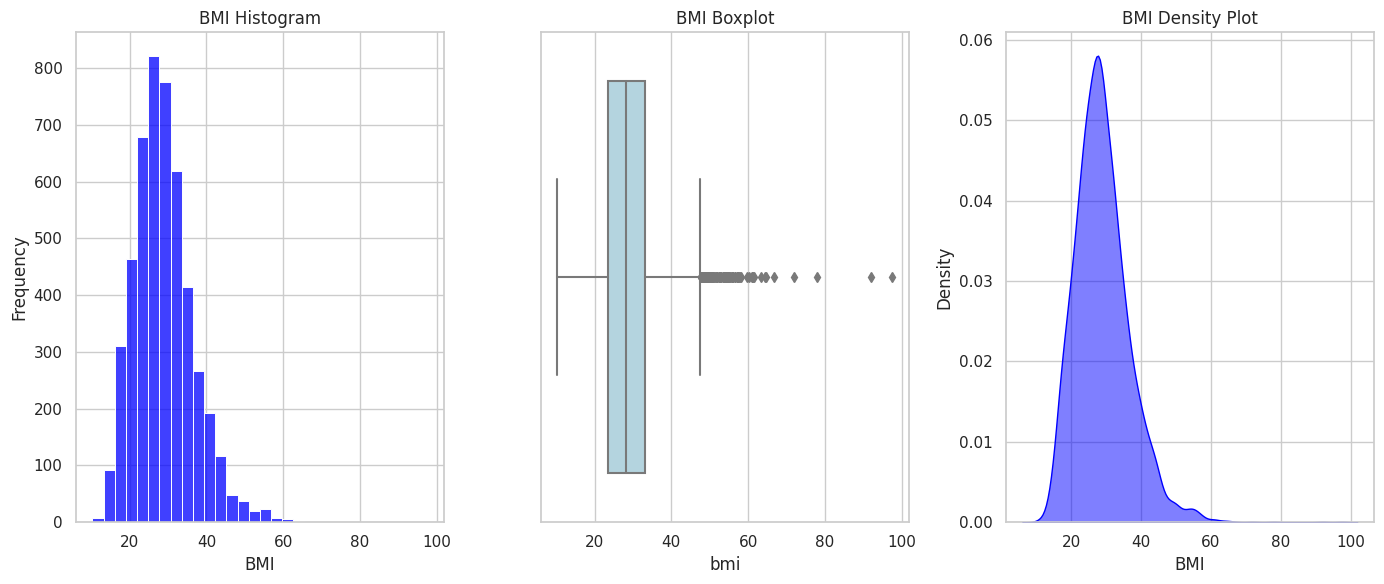

In [10]:
# First, let's drop missing values for the plots
bmi_data = df['bmi'].dropna()

# Style settings
sns.set(style="whitegrid")

# Creating the histogram
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(bmi_data, bins=30, kde=False, color='blue')
plt.title('BMI Histogram')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# Creating the boxplot
plt.subplot(1, 3, 2)
sns.boxplot(x=bmi_data, color='lightblue')
plt.title('BMI Boxplot')

# Creating the density plot
plt.subplot(1, 3, 3)
sns.kdeplot(bmi_data, fill=True, color='blue', alpha=0.5)
plt.title('BMI Density Plot')
plt.xlabel('BMI')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [11]:
# Calculate the correlation between 'stroke' and 'bmi' (There are 201 missing values)
correlation = df['stroke'].corr(df['bmi'])
print(f"Correlation between stroke and BMI: {correlation:.2f}")

Correlation between stroke and BMI: 0.04


Our correlation analysis revealed a coefficient of just 0.04 between Body Mass Index (BMI) and the incidence of stroke, indicating a very weak linear relationship between these two variables. However, numerous biological studies underscore the importance of BMI as a significant risk factor for stroke. For instance, research published in SAGE Open Medicine demonstrates that a higher BMI is linked to an increased risk of stroke and mortality within the general population (source: https://journals.sagepub.com/doi/10.1177/17474930241249370).

Given this context, we believe it is essential to retain the BMI variable for further investigation, despite the weak correlation observed in our analysis. To address the issue of missing values in the BMI column, we have opted to impute these values using the median. This strategy allows us to maintain the integrity of the variable while mitigating the influence of potential outliers.

In [12]:
# Filling missing values in the BMI column with the median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Displaying the updated DataFrame to confirm the changes made
print("Updated DataFrame after filling missing BMI values with the median:")
print(df.head())  # Displaying the first few rows of the updated DataFrame

Updated DataFrame after filling missing BMI values with the median:
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    male  67.0             0              1          Yes        Private   
1  female  61.0             0              0          Yes  Self-employed   
2    male  80.0             0              1          Yes        Private   
3  female  49.0             0              0          Yes        Private   
4  female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21  28.1     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  


In [13]:
# Summary statistics for numerical columns
summary_statistics = df[['age','avg_glucose_level','bmi']].describe()
print("\nSummary Statistics:\n", summary_statistics)


Summary Statistics:
                age  avg_glucose_level          bmi
count  5109.000000        5109.000000  5109.000000
mean     43.229986         106.140399    28.863300
std      22.613575          45.285004     7.699785
min       0.080000          55.120000    10.300000
25%      25.000000          77.240000    23.800000
50%      45.000000          91.880000    28.100000
75%      61.000000         114.090000    32.800000
max      82.000000         271.740000    97.600000


In [14]:
# Check unique values in categorical columns
for column in df.select_dtypes(include=['category']).columns:  
    print(f"\nUnique Values in '{column}':\n", df[column].value_counts())


Unique Values in 'gender':
 gender
female    2994
male      2115
Name: count, dtype: int64

Unique Values in 'ever_married':
 ever_married
Yes    3353
No     1756
Name: count, dtype: int64

Unique Values in 'work_type':
 work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Unique Values in 'Residence_type':
 Residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

Unique Values in 'smoking_status':
 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


## Correlation Analysis <a name="correlation-analysis"></a>
We will analyze the correlations between features in the dataset. This will help us identify which factors are most strongly related to stroke.



In this section, we will examine whether the categorical variables have any correlation with the stroke factor by visualizing bar plots. 

For each categorical column in the dataset, we will display the unique values and create a bar plot that shows the count of stroke occurrences (with and without stroke) for each category. This will help us identify patterns or relationships between the categorical variables and the likelihood of having a stroke.


Unique Values in 'gender':
 <bound method IndexOpsMixin.value_counts of 0         male
1       female
2         male
3       female
4       female
         ...  
5105    female
5106    female
5107    female
5108      male
5109    female
Name: gender, Length: 5109, dtype: category
Categories (2, object): ['female', 'male']>


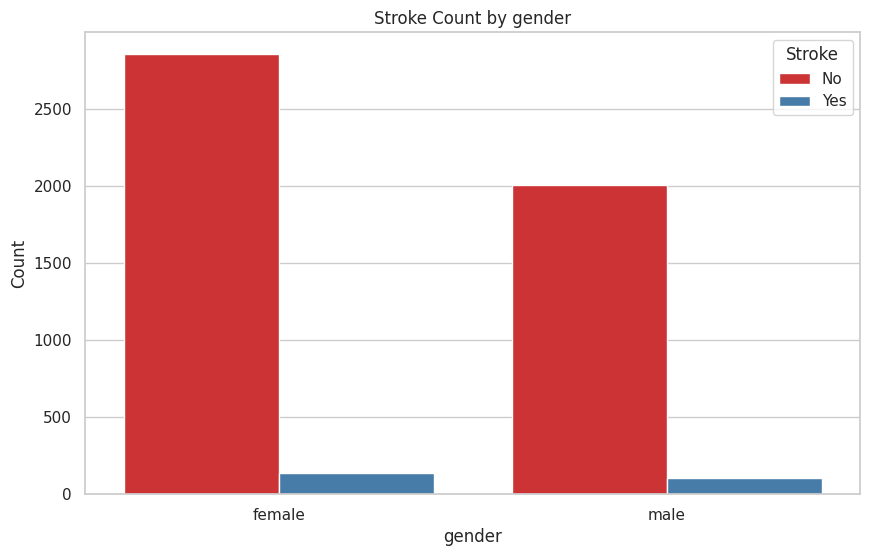


Unique Values in 'hypertension':
 <bound method IndexOpsMixin.value_counts of 0       0
1       0
2       0
3       0
4       1
       ..
5105    1
5106    0
5107    0
5108    0
5109    0
Name: hypertension, Length: 5109, dtype: int64>


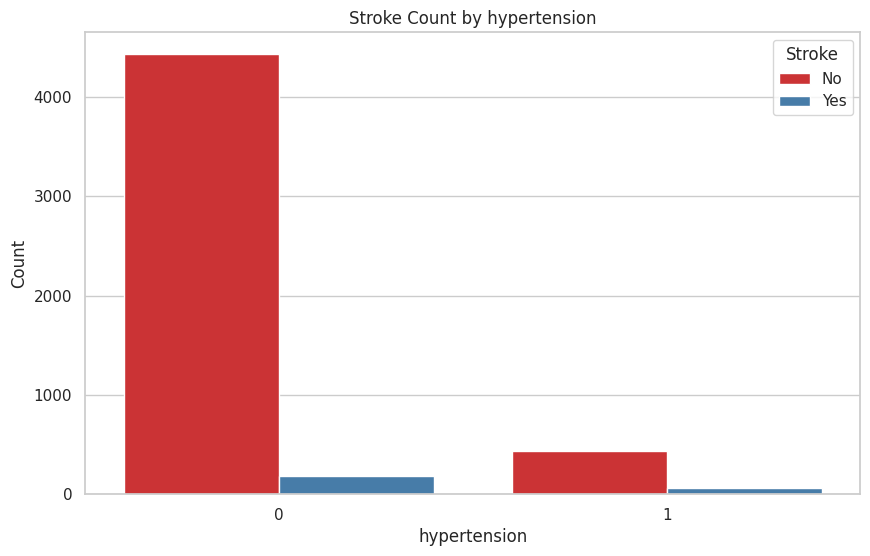


Unique Values in 'heart_disease':
 <bound method IndexOpsMixin.value_counts of 0       1
1       0
2       1
3       0
4       0
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: heart_disease, Length: 5109, dtype: int64>


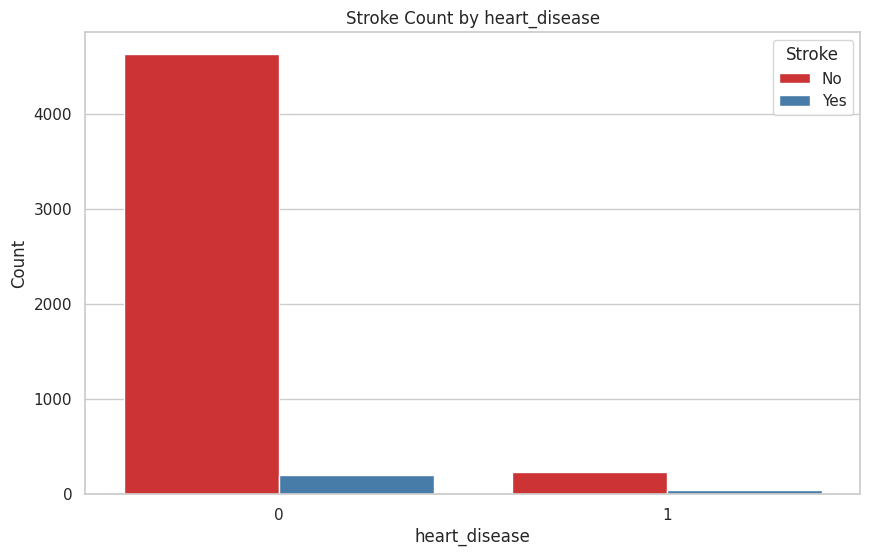


Unique Values in 'ever_married':
 <bound method IndexOpsMixin.value_counts of 0       Yes
1       Yes
2       Yes
3       Yes
4       Yes
       ... 
5105    Yes
5106    Yes
5107    Yes
5108    Yes
5109    Yes
Name: ever_married, Length: 5109, dtype: category
Categories (2, object): ['No', 'Yes']>


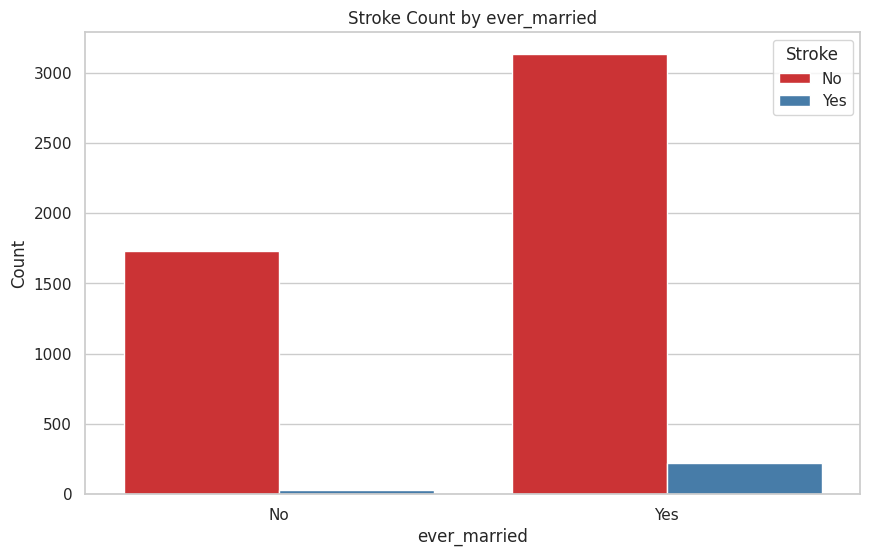


Unique Values in 'work_type':
 <bound method IndexOpsMixin.value_counts of 0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5109, dtype: category
Categories (5, object): ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']>


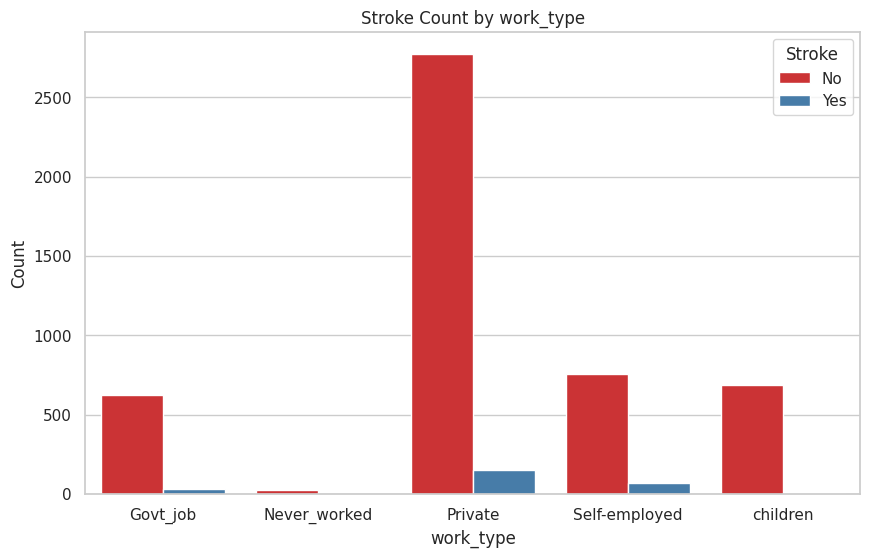


Unique Values in 'Residence_type':
 <bound method IndexOpsMixin.value_counts of 0       Urban
1       Rural
2       Rural
3       Urban
4       Rural
        ...  
5105    Urban
5106    Urban
5107    Rural
5108    Rural
5109    Urban
Name: Residence_type, Length: 5109, dtype: category
Categories (2, object): ['Rural', 'Urban']>


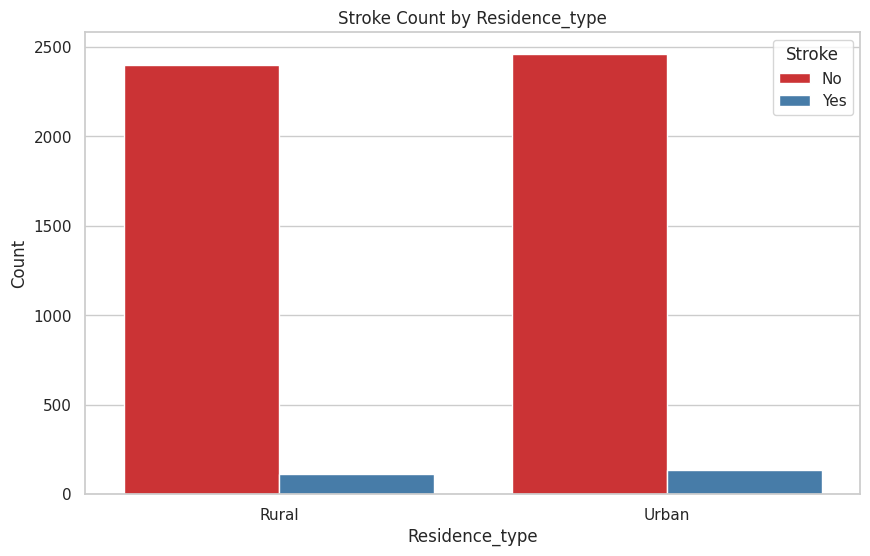


Unique Values in 'smoking_status':
 <bound method IndexOpsMixin.value_counts of 0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5109, dtype: category
Categories (4, object): ['Unknown', 'formerly smoked', 'never smoked', 'smokes']>


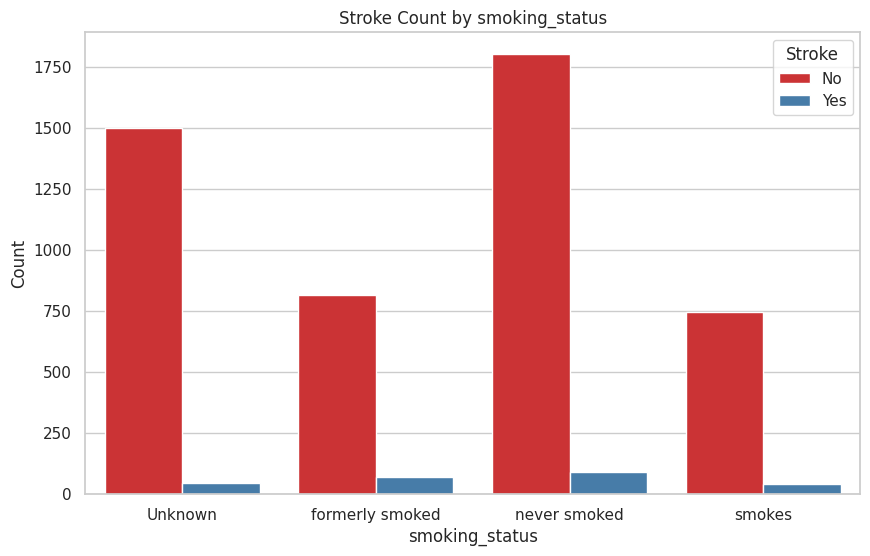

In [15]:
# Display unique values of the categorical columns

for column in ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']:
    print(f"\nUnique Values in '{column}':\n", df[column].value_counts)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, hue='stroke', palette='Set1')

    # Add title and labels
    plt.title(f'Stroke Count by {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Stroke', labels=['No', 'Yes'])

    # Show the plot
    plt.show()

Upon analyzing the bar charts, I observed that the variables worktype, residencetype, hypertension, ever married, heart disease, and smoking status did not show a significant correlation with the stroke condition. This suggests that these factors may not be strong indicators of stroke occurrence in the dataset we examined. It is important to note that while these variables are relevant in the context of health, their individual contributions to stroke risk may be limited, warranting further investigation into other potential risk factors.

Here we will conduct a similar analysis for numerical variables by creating scatter plots. For each numerical column in the dataset, we will visualize the relationship between the numerical variable and the stroke factor. This will help us identify any trends or correlations that may exist between numerical features and the likelihood of having a stroke.


Unique Values in 'age':
 count    5109.000000
mean       43.229986
std        22.613575
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64


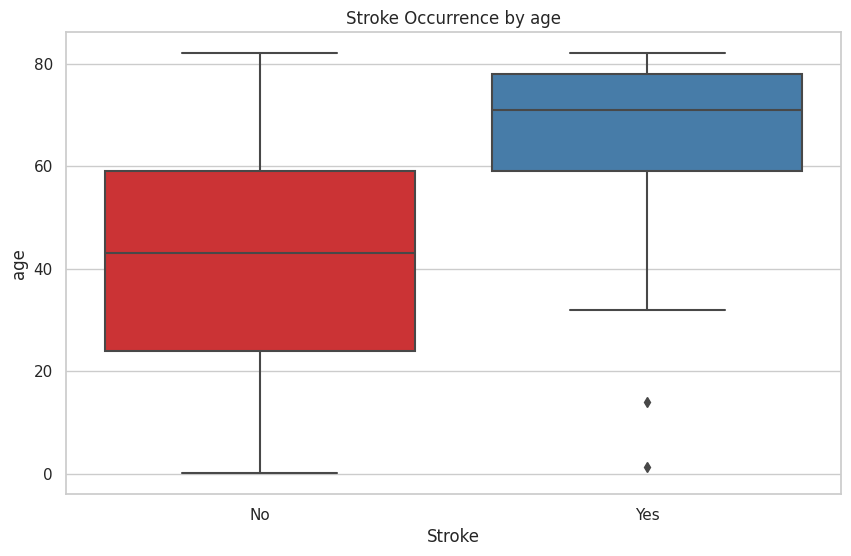


Unique Values in 'avg_glucose_level':
 count    5109.000000
mean      106.140399
std        45.285004
min        55.120000
25%        77.240000
50%        91.880000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64


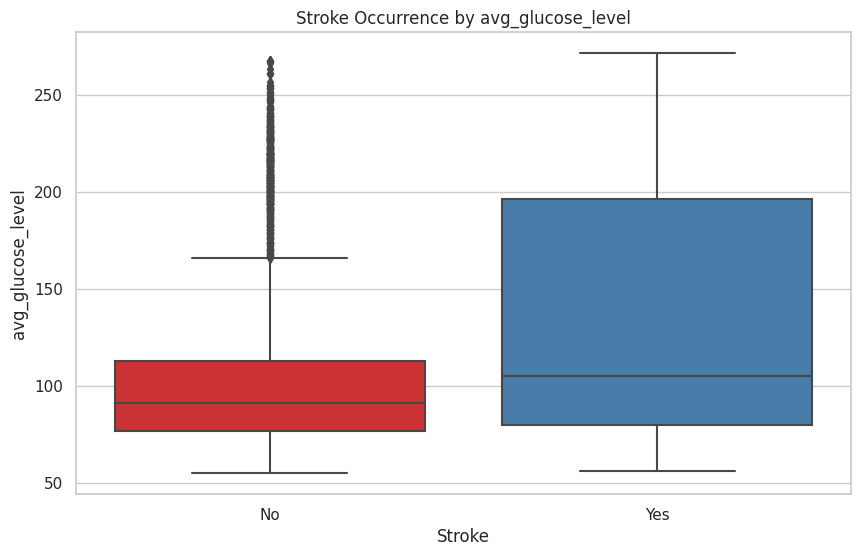


Unique Values in 'bmi':
 count    5109.000000
mean       28.863300
std         7.699785
min        10.300000
25%        23.800000
50%        28.100000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64


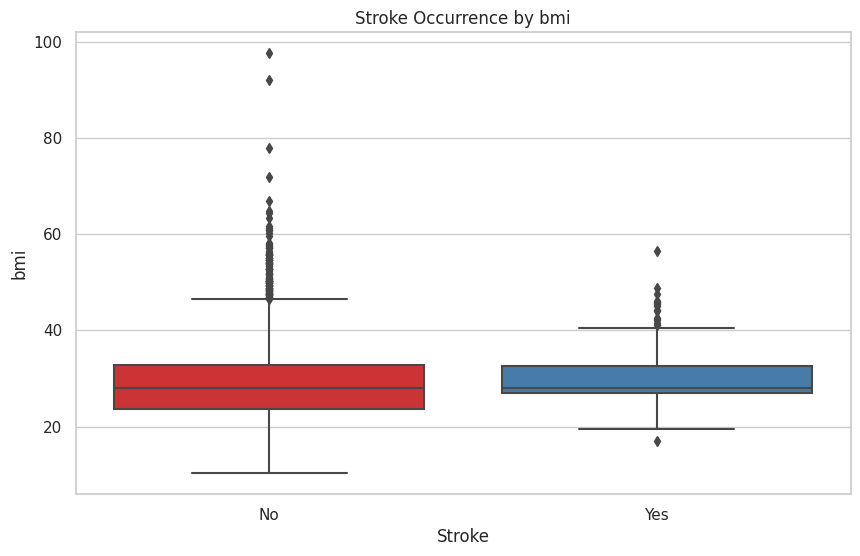

In [16]:
for column in ['age', 'avg_glucose_level', 'bmi']:
    print(f"\nUnique Values in '{column}':\n", df[column].describe())

    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='stroke', y=column, palette='Set1')

    # Add title and labels
    plt.title(f'Stroke Occurrence by {column}')
    plt.xlabel('Stroke')
    plt.ylabel(column)
    plt.xticks([0, 1], ['No', 'Yes'])  # Customize x-axis ticks for better readability

    # Show the plot
    plt.show()

After analyzing the boxplots, we can observe a significant trend in the presence of strokes among individuals aged between 60 and 80 years. Additionally, it is evident that glucose levels are a relevant factor, as we see a higher concentration of stroke observations in individuals with glucose levels above 120. On the other hand, regarding the BMI variable, we were unable to draw any conclusions from the data utilized.

In [17]:
# Normalize the 'gender' column
df['gender'] = df['gender'].str.strip().str.lower()

# Convert the 'ever_married' column to numeric
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0}).astype(int)

# Convert the 'hypertension' and 'heart_disease' columns to integers
df['hypertension'] = df['hypertension'].astype(int)
df['heart_disease'] = df['heart_disease'].astype(int)

# Apply One-Hot Encoding for other categorical variables
df = pd.get_dummies(df, columns=['work_type', 'Residence_type', 'smoking_status'], drop_first=True)

# Check the columns of the DataFrame after transformation
print("Columns of the DataFrame after encoding:")
print(df.columns.tolist())

# List of features to include in the correlation matrix
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 
            'stroke', 'gender', 'ever_married'] + [col for col in df.columns if col.startswith(('work_type_', 'Residence_type_', 'smoking_status_'))]

Columns of the DataFrame after encoding:
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'stroke', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


In [18]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply the encoder to the 'gender' column
df['gender'] = label_encoder.fit_transform(df['gender'])

# Check the data types after conversion
print("Data Types after gender encoding:")
print(df.dtypes)

Data Types after gender encoding:
gender                              int64
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                        int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Never_worked               bool
work_type_Private                    bool
work_type_Self-employed              bool
work_type_children                   bool
Residence_type_Urban                 bool
smoking_status_formerly smoked       bool
smoking_status_never smoked          bool
smoking_status_smokes                bool
dtype: object


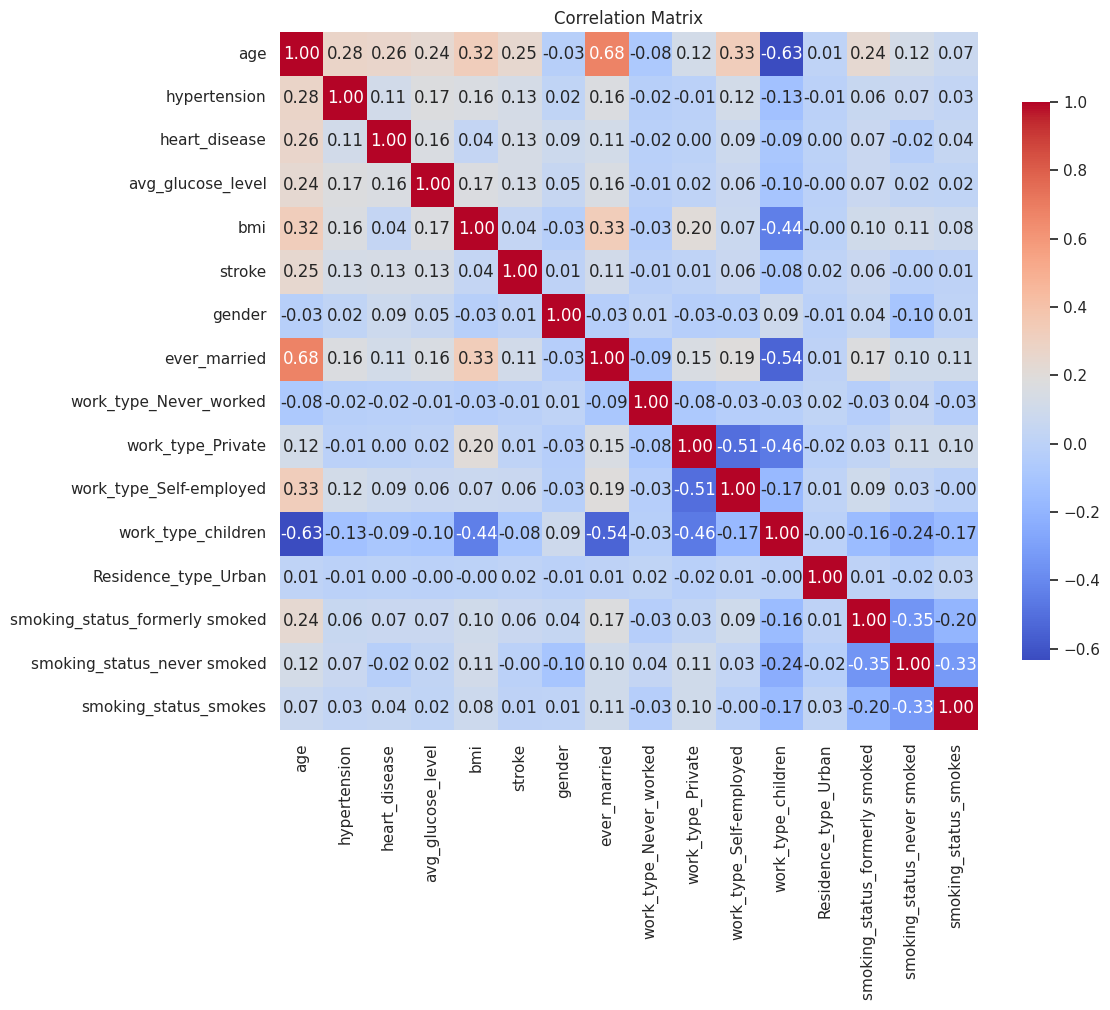

In [19]:
# Calculate the correlation matrix
correlation_matrix = df[features].corr()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure for the correlation heatmap
plt.figure(figsize=(12, 10))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title and labels
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

The correlation analysis revealed low correlations between the features and the stroke variable. 

Among all features, age exhibited the highest correlation with stroke, indicating that it may be a significant risk factor.

## Modeling <a name="modeling"></a>
In this section, we will build machine learning models to predict the likelihood of stroke occurrence based on various patient characteristics and health indicators. We will select appropriate algorithms and fit them to our training data, aiming to identify key risk factors and improve early detection strategies.

In [20]:
# Prepare the data
X = df.drop(columns=['stroke'])  # Remove the target variable from the DataFrame
y = df['stroke']  # Target variable

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit and transform the input data
X_scaled = scaler.fit_transform(X)

# If you want to keep X as a DataFrame, you can do the following:
X = pd.DataFrame(X_scaled, columns=X.columns)

In [21]:
# Split the data into training and testing sets
# Here we use 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [23]:
# Defining models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', C=1.0),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=5),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True),
    "XGBoost": XGBClassifier(scale_pos_weight=1, max_depth=5, n_estimators=100, use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_resampled, y_resampled)

## Model Evaluation <a name="model-evaluation"></a>
After building our models, we will evaluate their performance using various metrics. We will compare the predictions against the actual outcomes to determine how well our models are performing.

In [24]:
# Make predictions on the testing set
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.16      0.81      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.77      0.56      1022
weighted avg       0.93      0.74      0.81      1022

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       960
           1       0.16      0.66      0.26        62

    accuracy                           0.77      1022
   macro avg       0.57      0.72      0.56      1022
weighted avg       0.92      0.77      0.83      1022

Model: Random Forest
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       960
           1       0.15      0.77      0.25        62

    accuracy                           0.72      1022
   macro avg       0.56      0.74      0.54      1022
weigh

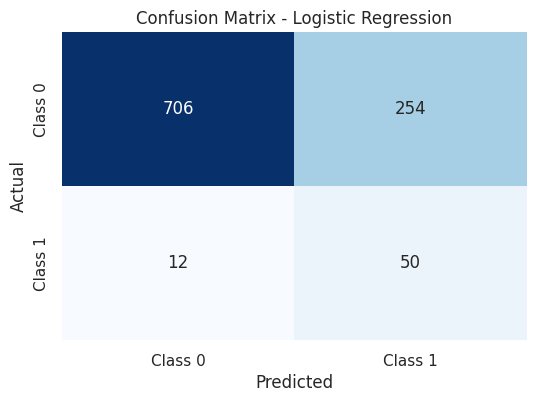

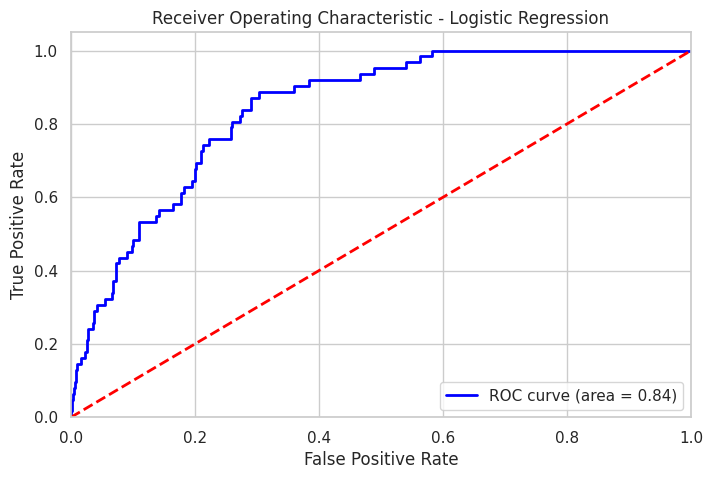

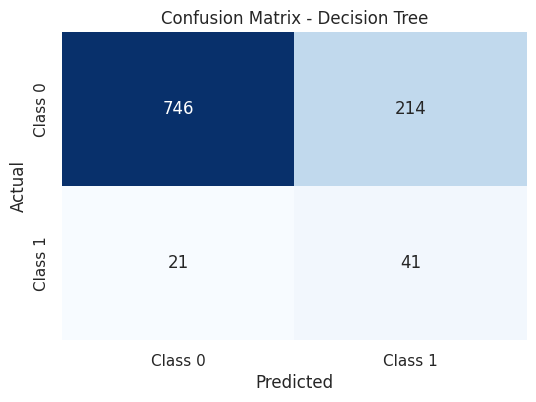

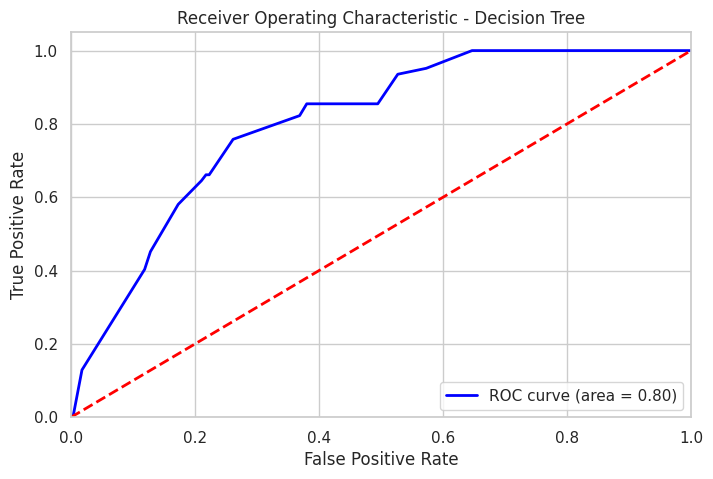

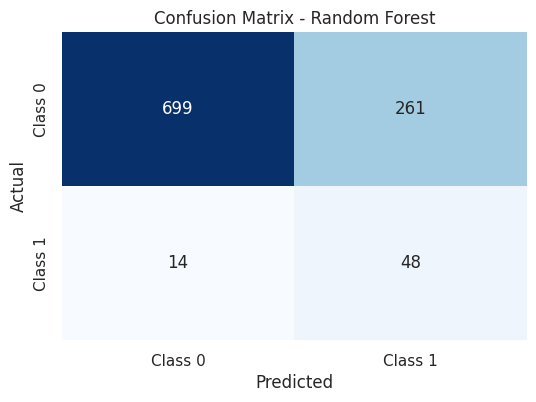

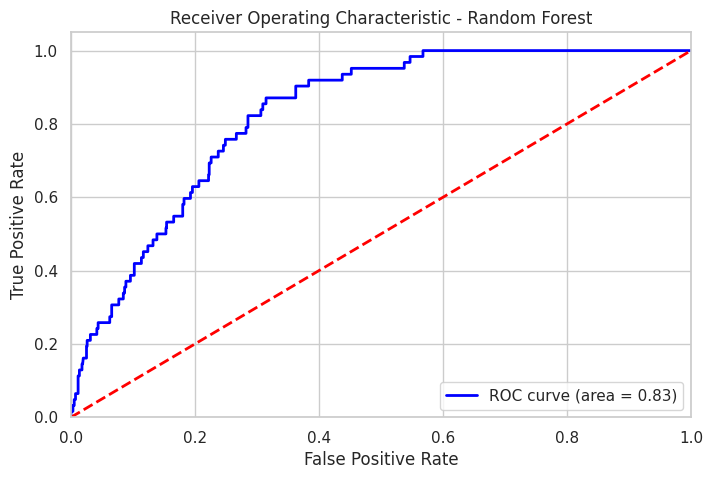

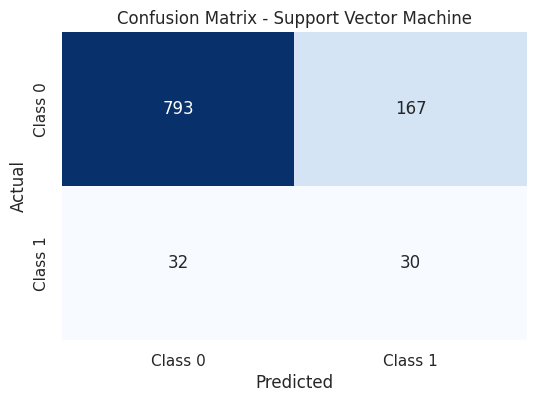

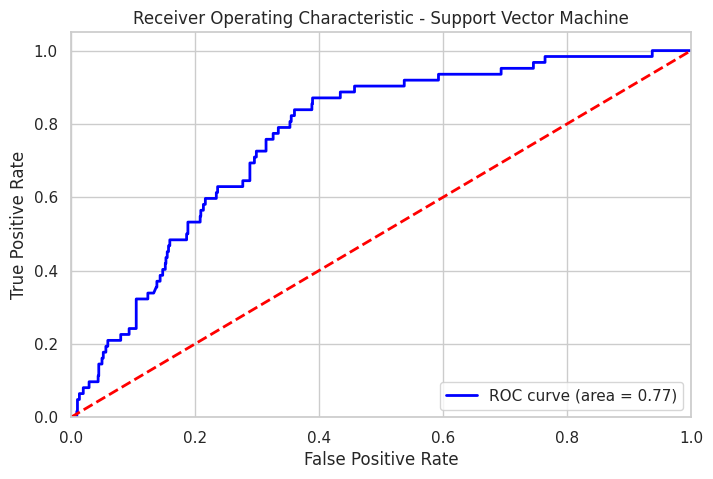

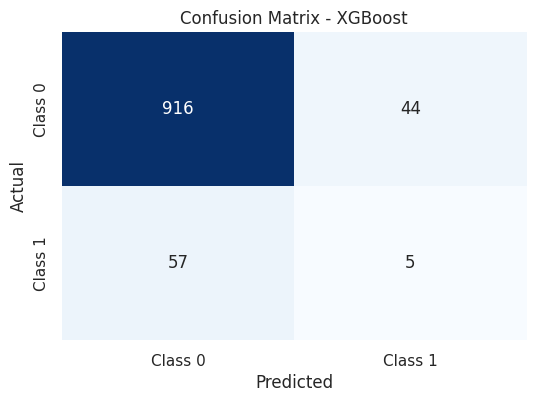

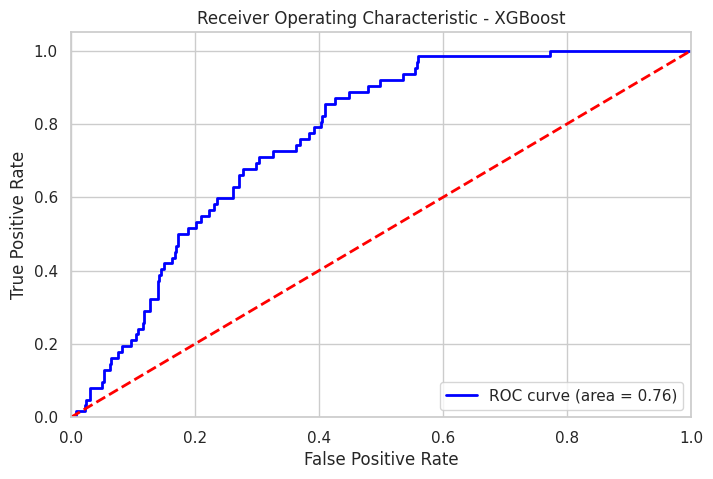

                    Model  Cross-Validated Accuracy  Std Dev Accuracy  \
0     Logistic Regression                  0.741247          0.019195   
1           Decision Tree                  0.765121          0.021731   
2           Random Forest                  0.741050          0.015297   
3  Support Vector Machine                  0.771385          0.010513   
4                 XGBoost                  0.943238          0.006548   

    ROC AUC  True Positive Rate  True Negative Rate  
0  0.843061            0.806452            0.735417  
1  0.803301            0.661290            0.777083  
2  0.827663            0.774194            0.728125  
3  0.765642            0.483871            0.826042  
4  0.762836            0.080645            0.954167  


In [25]:
# Initialize a list to store the results
results = []

# Training and evaluating each model
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()

    # Fit the model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate True Positive Rate (TPR) and True Negative Rate (TNR)
    TN, FP, FN, TP = conf_matrix.ravel()  # Unpack the confusion matrix
    tpr = TP / (TP + FN)  # True Positive Rate
    tnr = TN / (TN + FP)  # True Negative Rate

    # Calculate ROC curve
    fpr, tpr_roc, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr_roc)

    # Store results in the list
    results.append({
        'Model': name,
        'Cross-Validated Accuracy': mean_cv_score,
        'Std Dev Accuracy': std_cv_score,
        'ROC AUC': roc_auc,
        'True Positive Rate': tpr,
        'True Negative Rate': tnr
    })

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr_roc, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {name}')
    plt.legend(loc="lower right")
    plt.show()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results table
print(results_df)

Based on the results of the table, I will choose to implement Logistic Regression and Random Forest models for our analysis. Both models demonstrate good accuracy, with Logistic Regression achieving a cross-validated accuracy of approximately 74.12% and Random Forest at around 73.67%. More importantly, they exhibit higher true positive rates compared to other models, with Logistic Regression achieving a true positive rate of 80.65% and Random Forest at 77.42%.

Our primary objective is to effectively identify true positives—those individuals at risk of stroke—rather than solely focusing on true negatives. Therefore, prioritizing models that enhance our ability to detect true positives aligns with our goal of improving stroke detection efficacy.

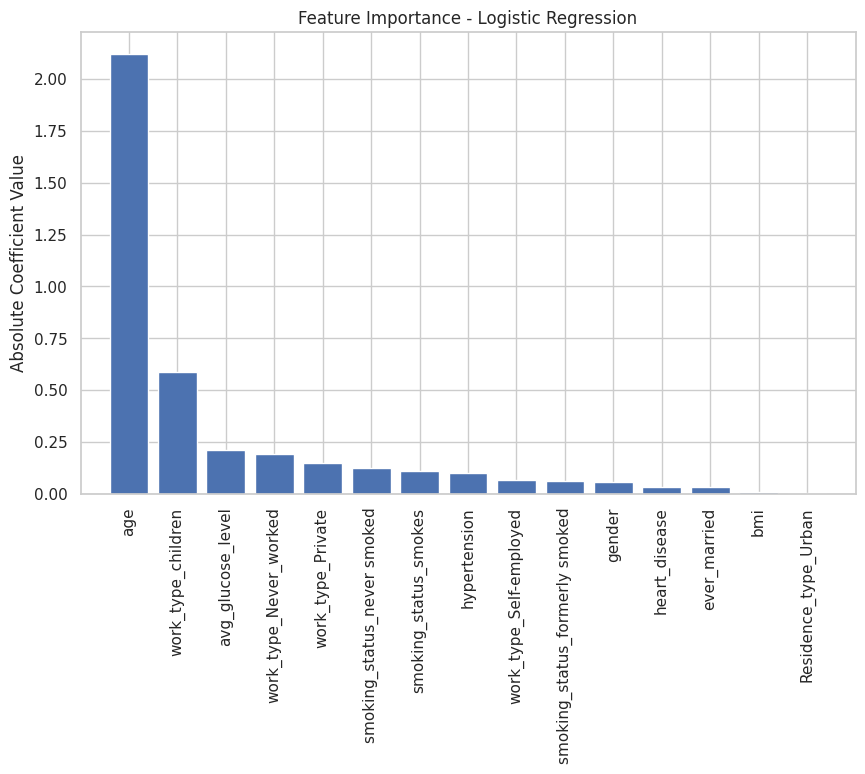

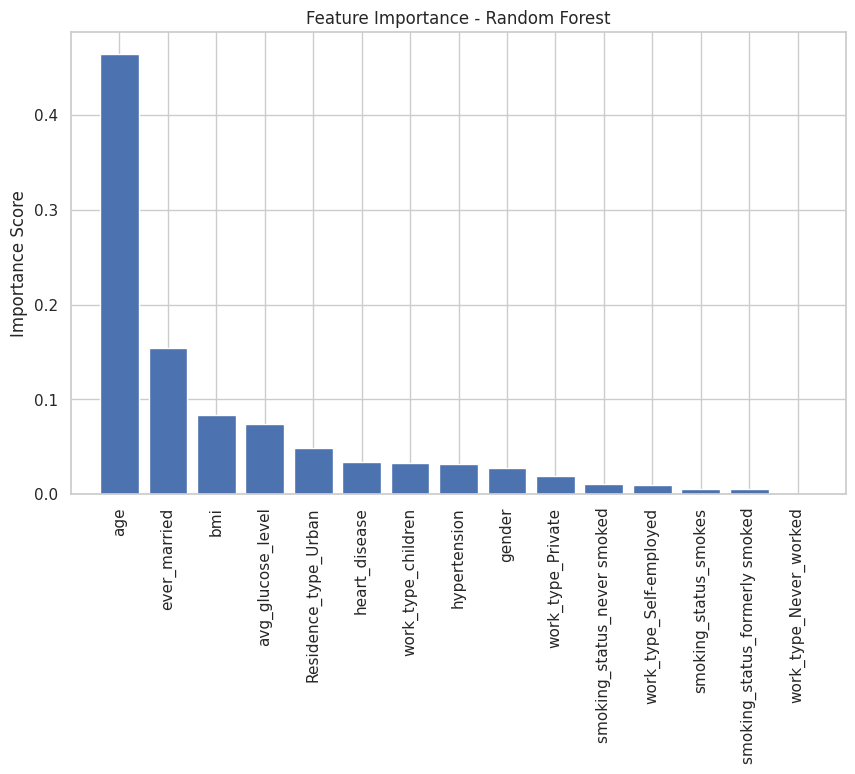

In [26]:
# Logistic Regression Model
logistic_model = models['Logistic Regression']

# Get coefficients and sort them
coefficients = logistic_model.coef_[0]
absolute_coefficients = np.abs(coefficients)  # Use absolute values for easier interpretation
indices = np.argsort(absolute_coefficients)[::-1]  # Sort by absolute values in descending order

# Plot feature importance for Logistic Regression
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Logistic Regression")
plt.bar(range(X.shape[1]), absolute_coefficients[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Absolute Coefficient Value")  # Change label to reflect absolute value
plt.show()

# Random Forest Model
random_forest_model = models['Random Forest']

# Get feature importances and sort them
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort importances in descending order

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance Score")
plt.show()

According to the feature importance graphs for both models, we can observe that two variables stand out as significant predictors of stroke. One of these variables has a very high coefficient in the Logistic Regression model, indicating its strong influence on the model's predictions. The other important variable is 'avg_glucose_level', which also plays a crucial role in both models. This suggests that monitoring these variables could be key in predicting stroke risk more effectively

## Conclusion and Next Steps

### Conclusion

The stroke prediction analysis conducted in this project underscores the critical nature of early detection and intervention in mitigating the impact of stroke, a leading cause of mortality worldwide. Using a dataset that encompasses various clinical attributes, we developed predictive models aimed at identifying individuals at high risk for stroke. 

Through exploratory data analysis (EDA) and feature correlation assessments, we identified age as the most significant predictor of stroke occurrence, while the relationship between Body Mass Index (BMI) and stroke incidence was minimal. The predictive models, particularly Logistic Regression and Random Forest, demonstrated promising performance, achieving cross-validated accuracies of approximately 74.12% and 73.67%, respectively. Notably, these models exhibited higher true positive rates, emphasizing their potential in effectively identifying at-risk individuals.

### Next Steps

To further enhance the predictive capabilities and clinical applicability of our models, the following steps are recommended:

1. **Model Refinement**: Explore additional machine learning algorithms, such as Gradient Boosting or ensemble methods, to improve performance metrics, particularly the true positive rate.

2. **Hyperparameter Tuning**: Implement techniques such as Grid Search or Random Search to optimize model parameters, which may yield better predictive accuracy.

3. **Feature Engineering**: Investigate additional features or transformations, including interaction terms or polynomial features, to capture more complex relationships within the data.

4. **Handling Imbalanced Data**: Experiment with advanced resampling techniques or cost-sensitive learning to address the class imbalance observed in the dataset effectively.

5. **Deployment and Validation**: Develop a user-friendly interface for healthcare professionals to utilize the predictive models in clinical practice. Additionally, validate the models using a separate test set or in real-world scenarios to assess their generalizability.

6. **Continuous Monitoring**: Establish a framework for continuous monitoring and updating of the models as new data becomes available, ensuring their relevance and accuracy over time.

By pursuing these next steps, we aim to enhance the predictive power of our models, ultimately contributing to better stroke prevention strategies and improved healthcare outcomes.